In [1]:
import scanpy as sc
import sklearn.model_selection as sks
import numpy as np
import pandas as pd
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import sklearn.metrics as skm
from itertools import cycle
import matplotlib.gridspec as gridspec
import matplotlib.colors as clr
from matplotlib.ticker import MaxNLocator

## LOAD Seurat object 

In [2]:
adata = sc.read_h5ad("data/cohort1.h5ad")
adata

AnnData object with n_obs × n_vars = 99049 × 46584
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'ref.celltype', 'batch.id', 'IDs', 'Condition', 'PoolID', 'Preparation', 'SampleID', 'Patient_ID', 'Samplename', 'CountDir', 'ExampleMetaData', 'GroupColor', 'Gender', 'Age', 'nCount_HTOsPool1', 'nFeature_HTOsPool1', 'hash.ID', 'HTOassignment', 'nCount_HTOsPool2', 'nFeature_HTOsPool2', 'nCount_HTOsPool3', 'nFeature_HTOsPool3', 'nCount_HTOsPool4', 'nFeature_HTOsPool4', 'nCount_HTOsPool5', 'nFeature_HTOsPool5', 'HTOsPool5_maxID', 'HTOsPool5_secondID', 'HTOsPool5_margin', 'HTOsPool5_classification', 'HTOsPool5_classification.global', 'nCount_HTOsPool6', 'nFeature_HTOsPool6', 'HTOsPool6_maxID', 'HTOsPool6_secondID', 'HTOsPool6_margin', 'HTOsPool6_classification', 'HTOsPool6_classification.global', 'HTOshortIDs', 'DaysAfterSample0', 'DaysAfterSymp', 'Sampling_date', 'percent.hb', 'integrated_snn_res.0.6', 'celltype', 'id.celltype', 'clus

In [6]:
print(adata.obs.apply(lambda col: col.unique()))

orig.ident          [Covid19, sepsis, one_k_v3, Five_k_v3, Ten_k_v3]
nCount_RNA         [4842.0, 9582.0, 4484.0, 2971.0, 3244.0, 2655....
nFeature_RNA       [1925, 3004, 1950, 1555, 1368, 1136, 1406, 167...
percent.mt         [6.608839322593969, 4.19536631183469, 5.575379...
RNA_snn_res.0.5    [7, 9, 5, 18, 3, 1, 15, 4, 10, 8, 12, 2, 20, 1...
                                         ...                        
nReads_RNA         [4842.0, 9582.0, 4484.0, 2971.0, 3244.0, 2655....
patien_id          [C19-CB-01, C19-CB-03, C19-CB-02, C19-CB-05, C...
sample_id          [C19-CB-01_d11, C19-CB-03_d13, C19-CB-02_d13, ...
nReads_ALL         [5102.0, 10008.0, 4629.0, 3506.0, 3690.0, 3108...
celltypeL0            [0, 9, 11, 4, 7, 6, 8, 10, 1, 5, 2, 13, 12, 3]
Length: 75, dtype: object


In [60]:
adata.obs.nunique().keys()[(adata.obs.nunique().values<30) & (adata.obs.nunique().values>19)]

Index(['RNA_snn_res.0.5', 'seurat_clusters', 'IDs', 'integrated_snn_res.0.6',
       'id.celltype', 'cluster.sort', 'Patient', 'RNA_snn_res.0.4', 'new.id',
       'Patient_date'],
      dtype='object')

In [57]:
np.unique(adata.obs.stage)

array(['control', 'early', 'late'], dtype=object)

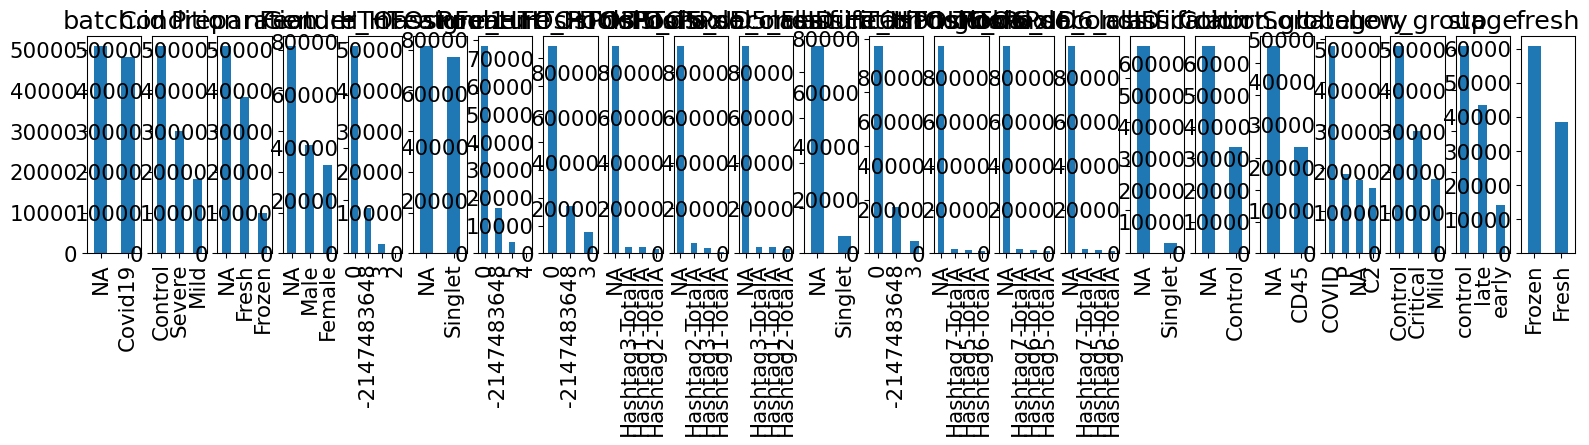

In [46]:
with rc_context({'figure.figsize': (20, 3), 'figure.dpi':96, 'font.size' :16}):
    categorical_features = adata.obs.nunique().keys()[(adata.obs.nunique().values<5) & (adata.obs.nunique().values>1)  ]
    fig, ax = plt.subplots(1, len(categorical_features))
    for i, categorical_feature in enumerate(adata.obs[categorical_features]):
        adata.obs[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
    fig.show()


Load cell annotation from the published clustering

In [ ]:
ident=pd.read_csv('data/active_ident_cohort1.csv', index_col = 0)

### Bring WHO score for COVID patients from csv sheet 

In [4]:
who =np.array([['1','2','3','5','52','53','204','214','8','9','11','12','13','16','20','21','198','199'],[3,3,3,3,4,4,3,3,
                                                                                                       7,7,5,7,7,7,7,6,6,7]]).transpose()


In [6]:
who_score = pd.DataFrame(data=who, columns = ['pID','who'])
adata.obs['who_score']= np.nan
metadata = adata.obs.merge( who_score, how='left', left_on='Patient_ID', right_on='pID')
metadata = metadata.set_index(adata.obs.index)

## Use metadata object to manipulate meta data

In [8]:
metadata= metadata.replace('NA', np.nan)


## Start prediction ....

Split COVID data (exclude control samples) : 75% training set and 25% test set by preserving classes percentages

In [15]:
df= adata.obsm['X_harmony'][adata.obs['Condition']!= 'Control']
meta = adata.obs[adata.obs['Condition']!= 'Control']
df = pd.DataFrame(df, index = meta.index)
y = metadata[metadata['Condition']!= 'Control'].who
train, test, y_train, y_test = sks.train_test_split(df.loc[:,0:19],y, test_size=0.25, random_state=42, stratify=y)

Statistics about the split

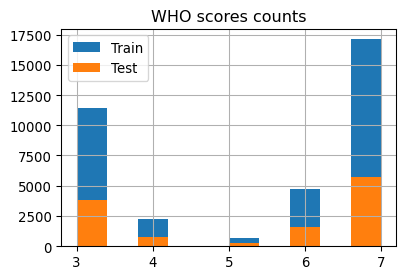

In [17]:
with plt.rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96}):
    fig, ax = plt.subplots()
    y_train.sort_values().hist( ax=ax)
    y_test.hist( ax=ax)
    ax.legend(['Train','Test'])
    plt.title('WHO scores counts')


In [19]:
metadata['split']= None
metadata.loc[metadata.index.isin(train.index),'split']=0
metadata.loc[metadata.index.isin(test.index),'split']=1

### Apply SVM with cross-validated grid-search over a parameter grid

In [ ]:
c_values = [0.1, 0.5, 1.0, 1.5,  2.0]
kernel_values = [ 'linear' ,  'poly' ,  'rbf' ,  'sigmoid' ]
class_weight = ['balanced', None]
hyperparam_grid = dict(C=c_values, kernel=kernel_values, class_weight= class_weight)
s = svm.SVC(random_state=42,  probability=True)
clf = sks.GridSearchCV(s,hyperparam_grid,scoring='f1',cv=5, refit=True)
grid_result = clf.fit(train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pred=clf.predict(test)

In [21]:
metadata['svm']= None
metadata.loc[test.index,'svm']=pred

### Append classification to  metadata

In [23]:
adata.obs['split'] = metadata['split']
adata.obs['svm'] = metadata['svm'].astype(str)
adata.obs['who'] = metadata['who']

## Plot UMAP with real and predicted classes

Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ref.celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch.id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'IDs' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Condition' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'PoolID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Preparation' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SampleID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Patient_ID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Samplename' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'CountDir' as categorical
Trying to set attribute `.obs` of vi

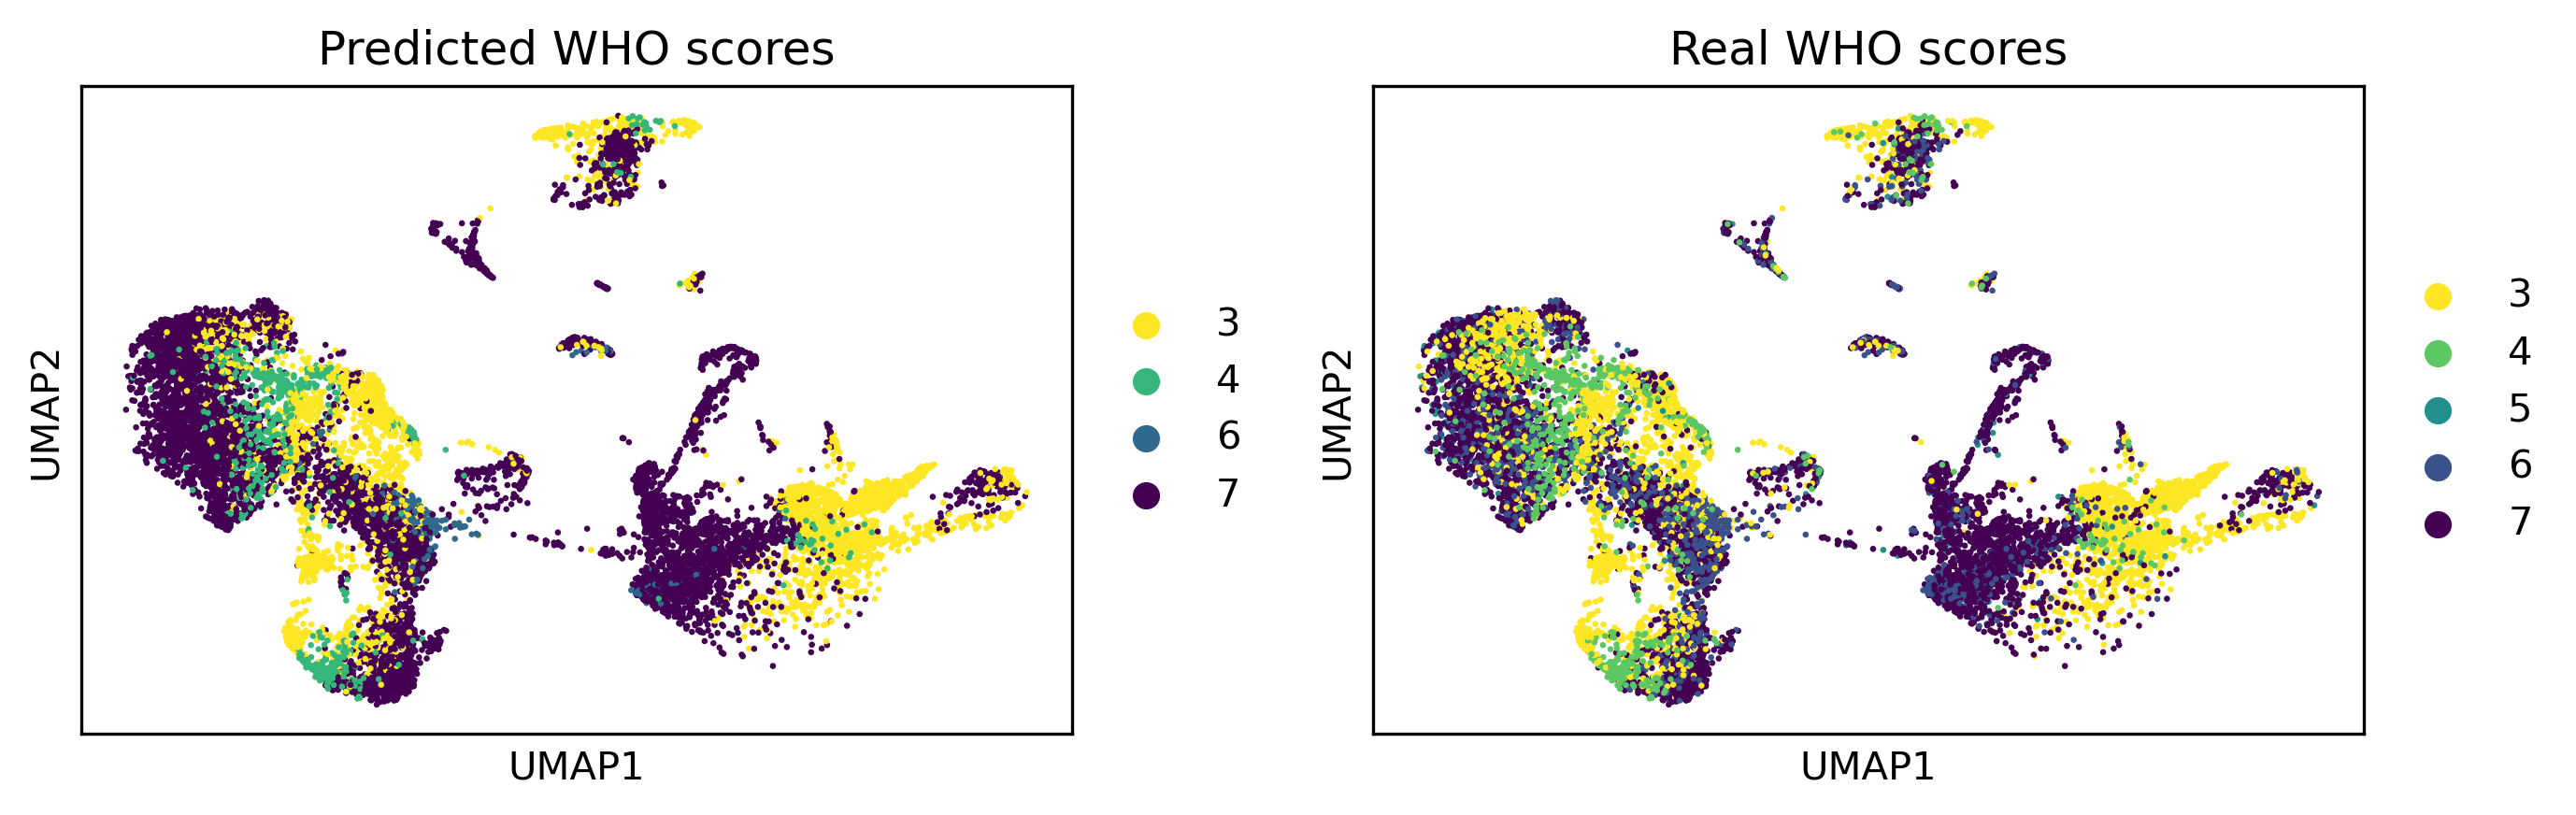

In [24]:
with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':300}):
    sc.pl.umap(
        adata[adata.obs["split"] == 1],
        color=["svm",'who'],
        palette='viridis_r',
        title = ['Predicted WHO scores','Real WHO scores']
    )

## Some evaluation metrics ...

### Classification report

In [134]:
print(skm.classification_report(y_test, pred, target_names=clf.classes_))

              precision    recall  f1-score   support

           3       0.89      0.89      0.89      3813
           4       0.88      0.87      0.87       736
           5       1.00      0.03      0.05       233
           6       0.73      0.34      0.46      1570
           7       0.79      0.94      0.86      5715

    accuracy                           0.82     12067
   macro avg       0.86      0.61      0.63     12067
weighted avg       0.82      0.82      0.80     12067



### ROC curves

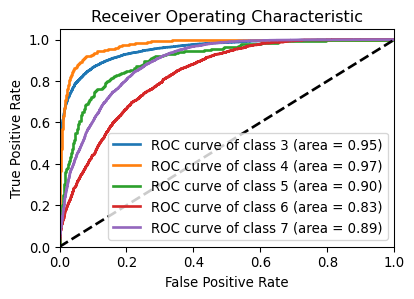

In [27]:
y_score = clf.predict_proba(test)
n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = skm.roc_curve(pd.get_dummies(y_test).loc[:, clf.classes_[i]], y_score[:, i])
    roc_auc[i] = skm.auc(fpr[i], tpr[i])

with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96}):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label="ROC curve of class {0} (area = {1:0.2f})".format(clf.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()


### Confusion matrix

In [214]:
# pred_df = pd.DataFrame({"y":y_test,"pred":pred, "value":pred})
# pred_df.pivot_table(index='y', columns='pred',values='value',aggfunc='count')

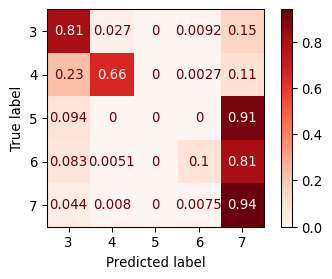

In [28]:
with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96}):
    skm.ConfusionMatrixDisplay.from_estimator(
         clf, test, y_test, normalize='true', cmap='Reds')
    plt.show()

## Investigate classification of cells

In [ ]:
celltype=ident.loc[test.index,'cohort1@active.ident']
dat = pd.DataFrame({"y":y_test,"pred":pred, "celltype":celltype})
dat=pd.DataFrame({'Count' : dat.groupby(['y', 'pred','celltype']).size()}).reset_index()

dat = dat.groupby(["y", "pred", "celltype"])["Count"].sum().unstack(fill_value=0)

dat = dat.div(dat.sum(axis=1), axis=0)
# plotting

clusters = dat.index.levels[0]
inter_graph = 0
maxi = np.max(np.sum(dat, axis=1))
total_width = len(dat)+inter_graph*(len(clusters)-1)

fig = plt.figure(figsize=(total_width,10))
gridspec.GridSpec(1, total_width)
axes=[]
cmap = clr.LinearSegmentedColormap.from_list(
    "", ['#839192','#641e16','#e74c3c','#92f5b9',
         '#aed6f1','#17202a','#f9e79f','#f8c471','#0b2f99','#d7bde2','#d4efdf','#abebc6','#fcf3cf','#d4e6f1'])
ax_position = 0
with rc_context({'figure.figsize': (4.5, 3), 'figure.dpi':96, 'font.size' :16}):

    for cluster in clusters:
        subset = dat.loc[cluster]
        ax = subset.plot(kind="bar", colormap = cmap,stacked=True, width=1, ax=plt.subplot2grid((1,total_width), (0,ax_position), colspan=len(subset.index)))
        axes.append(ax)
        ax.set_title(cluster)
        ax.set_xlabel("")
        ax.set_ylim(0,maxi)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_position += len(subset.index)+inter_graph

    for i in range(1,len(clusters)):
        axes[i].set_yticklabels("")
        axes[i-1].legend().set_visible(False)
    axes[0].set_ylabel("Percentages")

    fig.suptitle('Fraction of cell types in the predicted WHO classes grouped by true classes', fontsize="x-large")
    legend = axes[-1].legend(loc="upper right", fontsize=16, framealpha=1, bbox_to_anchor=(2.5, 1)).get_frame()
    legend.set_linewidth(3)
    legend.set_edgecolor("black")

    plt.show()